In [6]:
import photutils, astropy
from photutils import datasets
from astropy.modeling.functional_models import Sersic2D

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

from astropy import visualization, convolution, stats

from collections import OrderedDict

import time

import ashd

from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord

import subprocess

import skimage
from skimage import morphology, restoration

import sep

%matplotlib inline

#import mpld3
#mpld3.enable_notebook()

plt.rcParams['figure.figsize'] = [18, 18]

In [23]:
def ds9me(val): subprocess.Popen(["/usr/bin/ds9", val])

norm = visualization.mpl_normalize.ImageNormalize(
    stretch=visualization.SqrtStretch())

def plotme(obj, rng=[10, 99]):
    vmin, vmax = np.percentile(obj, rng)
    plt.imshow(obj, cmap="Greys_r", norm=norm, vmin=vmin, vmax=vmax)

In [38]:
def cut_corners(objlist, thresh=30, size=[2048, 2048]):
    for i in objlist:
        x = i['x']; y = i['y']
        if not (x < thresh and y < thresh) and not (x > (size[0] - thresh) and y < thresh):
            if not (x < thresh and y > (size[1] - thresh)) and not (x > (size[0] - thresh) and y > (size[1] - thresh)):
                yield i
    

In [3]:
butler = ashd.Butler(data_dir="/run/media/me/DATA/asas-sn-images")

In [4]:
coord = SkyCoord("02h39m59.3s −34d26m57s")
imgn = butler.get_image_fn(ra=coord.ra.deg,dec=coord.dec.deg)
#ds9me(imgn)

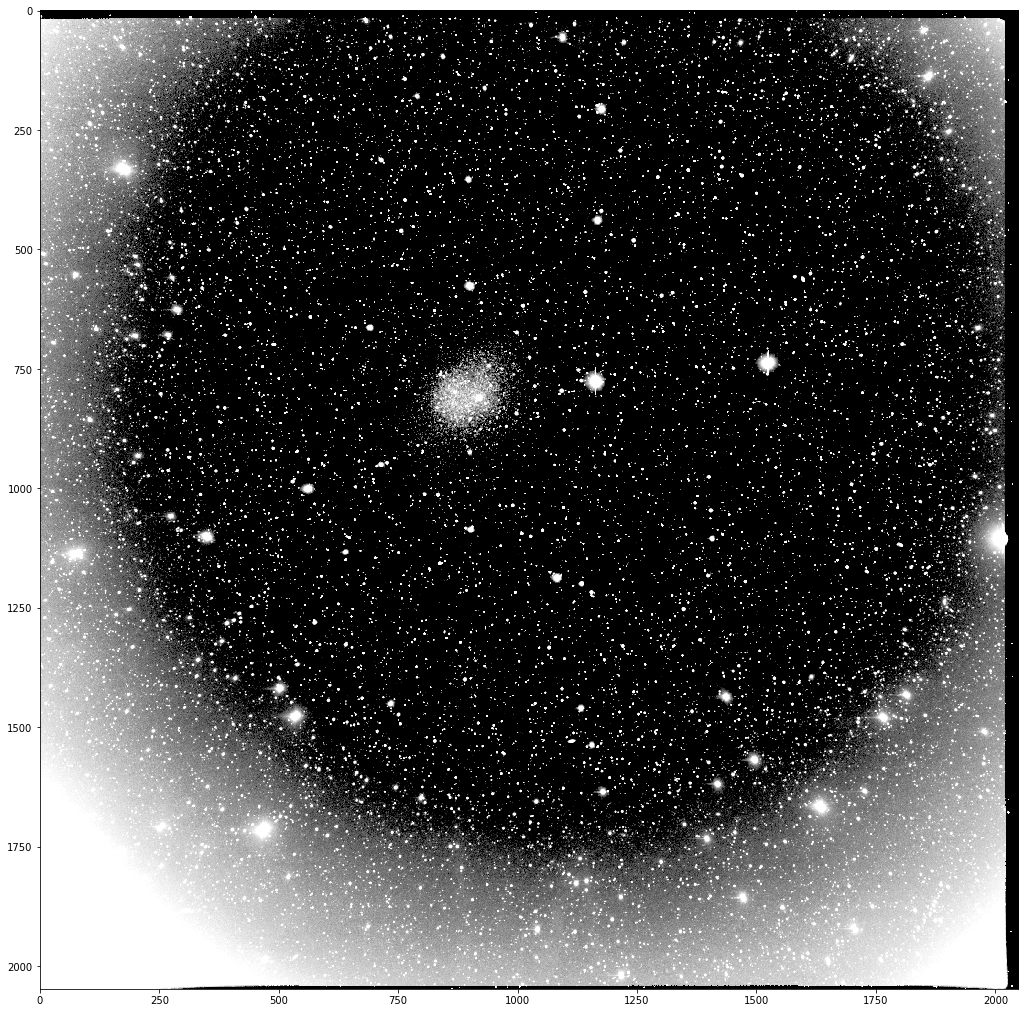

In [7]:
img = fits.open(imgn)
data = img[0].data
vmin, vmax = np.percentile(data, [60, 95])
#data[~(data > vmin)] = 0
plt.imshow(data, cmap="Greys_r", norm=norm, vmin=vmin, vmax=vmax)

In [8]:
NBINS = 1000
print(f'Max: {np.max(data)}')

Max: 533175.0


/home/me/anaconda3/envs/astro/lib/python3.7/site-packages/skimage/morphology/extrema.py:239: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  image[sl] = value
/home/me/anaconda3/envs/astro/lib/python3.7/site-packages/skimage/morphology/extrema.py:242: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  image[sl] = value


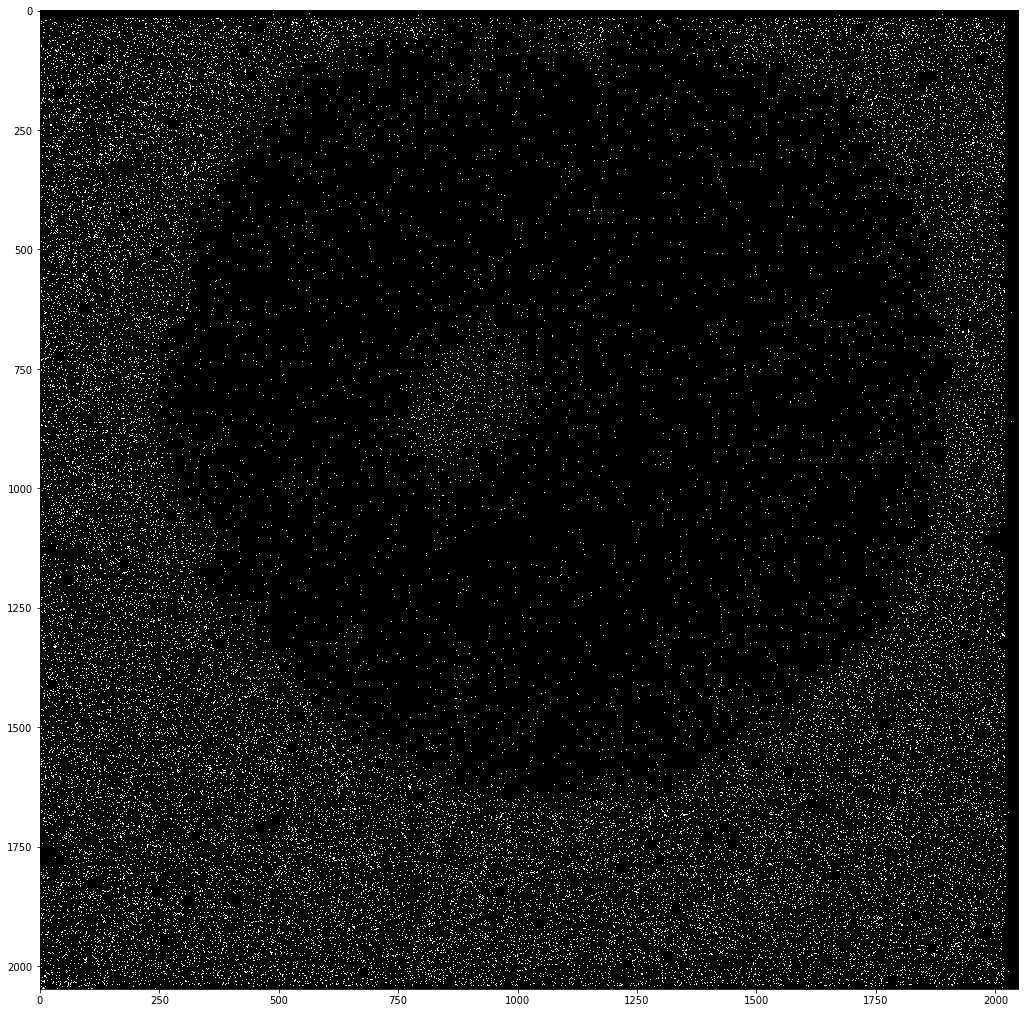

In [9]:
limg = np.arcsinh(data)
limg[~(limg > 6.9)] = 0
lm = morphology.local_maxima(limg)
plt.imshow(lm, cmap="Greys_r")

In [10]:
yeet = np.sort(data.flatten())
np.amax(yeet)
np.percentile(yeet, [10,99])


array([478.48355103, 959.22449097])

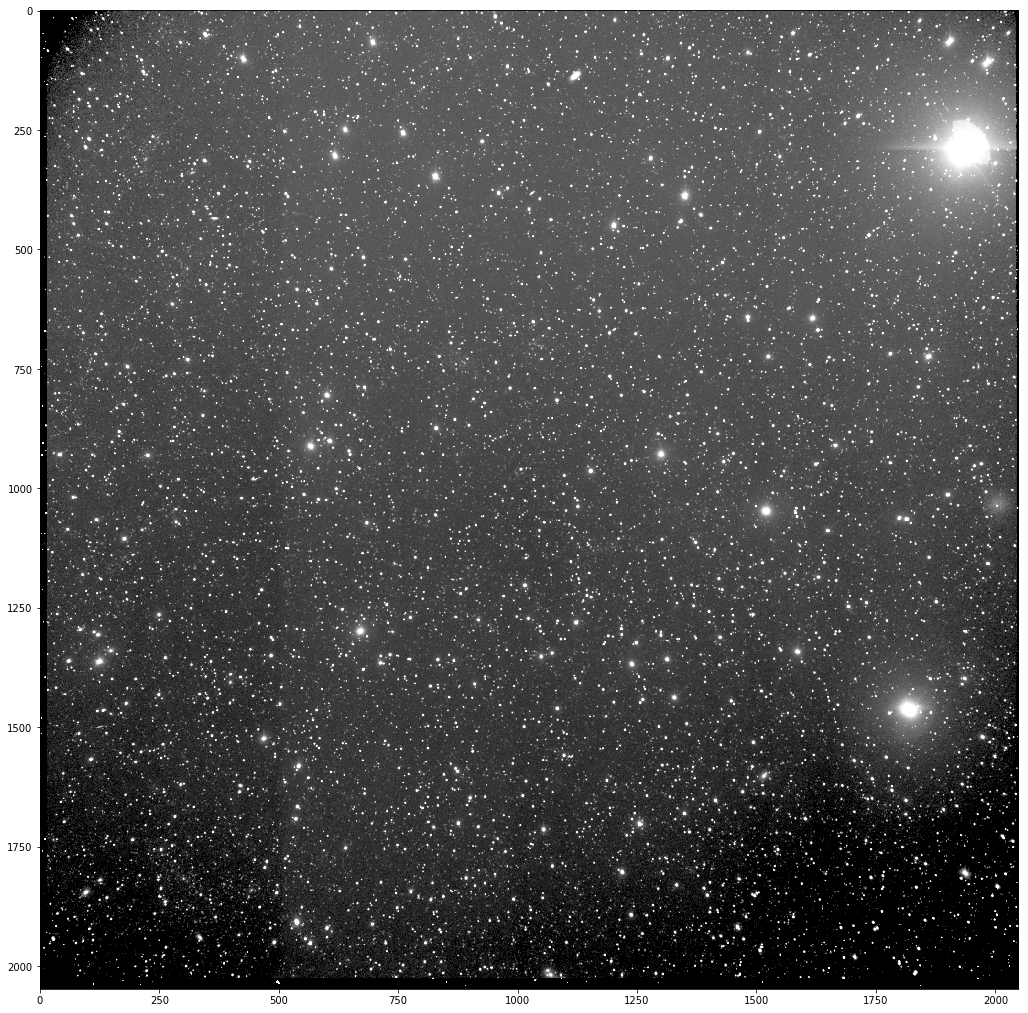

In [11]:
imgn2 = butler.get_image_fn(ra=168.37, dec=22.151)
img2 = fits.open(imgn2)
data2 = img2[0].data
plotme(data2)

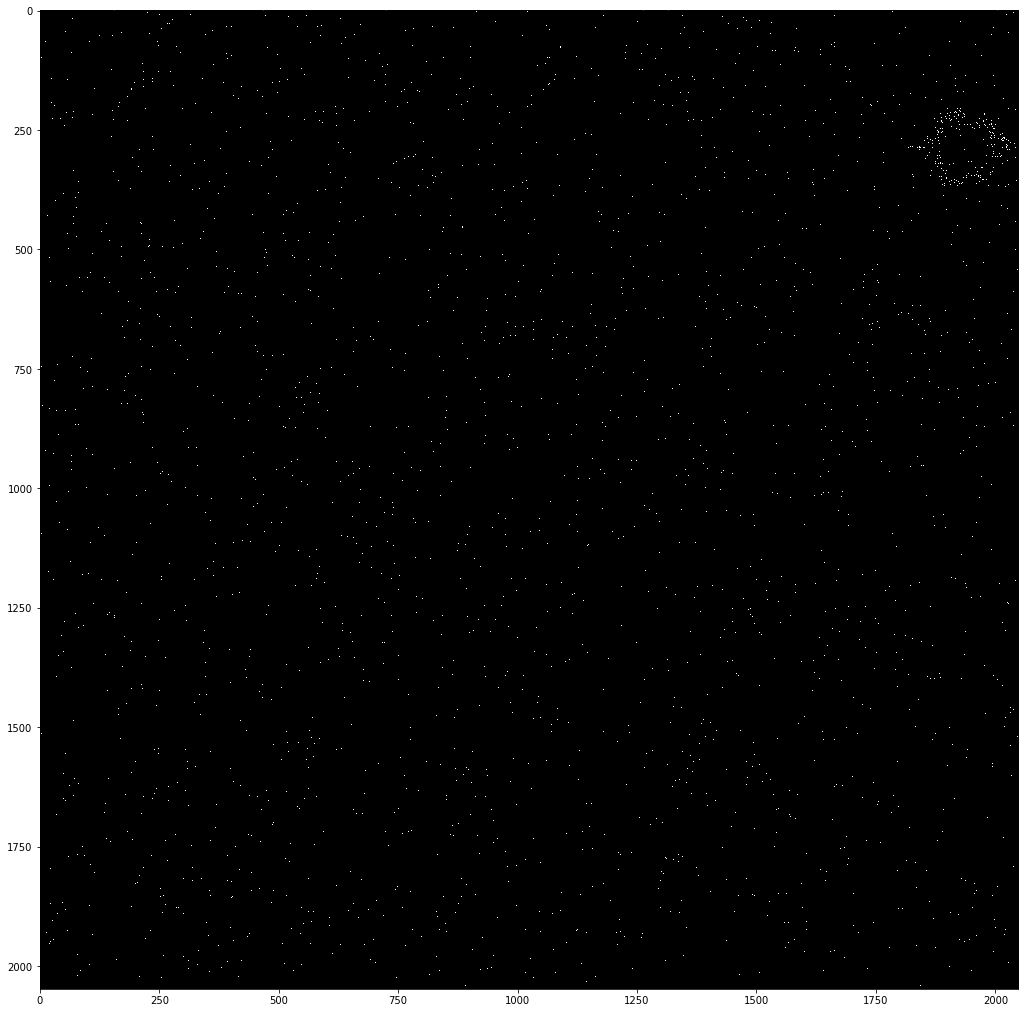

In [12]:
limg = np.arcsinh(data2)
limg[~(limg > 6.7)] = 0
lm = morphology.local_maxima(limg)
plt.imshow(lm, cmap="Greys_r")

In [13]:
data3 = data.byteswap().newbyteorder()
background = sep.Background(data3)

In [14]:
data_sub = data - background
objects = sep.extract(data_sub, 1.5, err=background.globalrms)

21.664057941416736; 1882.062478062478; skipped!
1198.8472772640541; skipped!
1639.10264301231; skipped!
1292.4360313315926; skipped!
1086.2187854067529; skipped!
7899.537435137138; skipped!
1301.5856717159177; skipped!


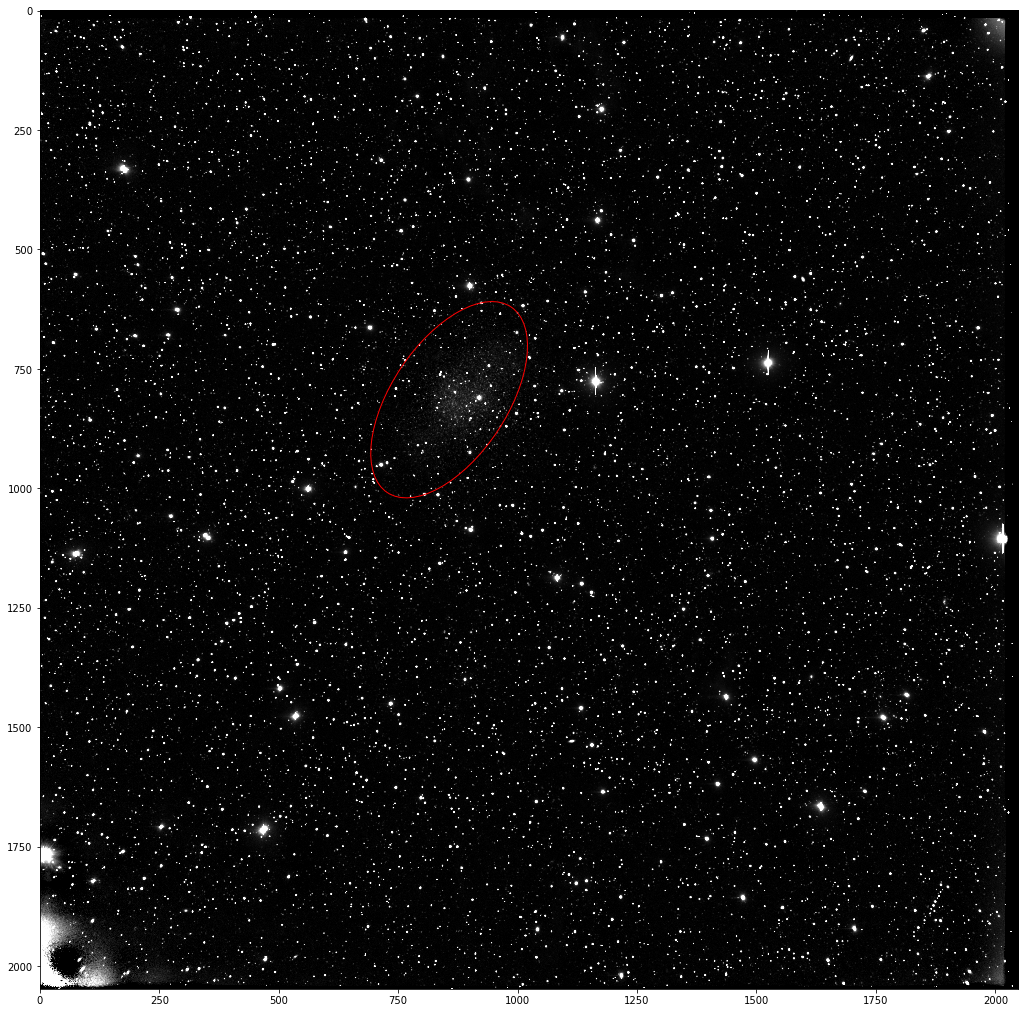

In [60]:
fig, ax = plt.subplots()
#m, s = np.mean(data_sub), np.std(data_sub)
vmin, vmax = np.percentile(data_sub, [10,99])
im = ax.imshow(data_sub, interpolation='nearest', origin='upper', cmap='Greys_r',
               vmin=vmin, vmax=vmax)

largest = sorted(objects, key=lambda x: x['npix'], reverse=True)[0:11]

avgsb = np.mean(objects['cflux'] / objects['npix'])

# plot an ellipse for each object
for obj in cut_corners(largest, thresh=200):
    sb = obj['cflux'] / obj['npix']
    print(sb, end="; ")
    if sb > avgsb:
        print("skipped!")
        continue
    e = patches.Ellipse(xy=(obj['x'], obj['y']),
                width=6*obj['a'],
                height=6*obj['b'],
                angle=obj['theta'] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)


In [16]:
sorted(objects, key=lambda x: x['npix'], reverse=True)[0:3]

[(3.51021242, 25707, 23375, 734, 1066, 651, 986, 856.70817625, 814.5179527, 2988.33537425, 4687.90401196, -2046.8149852, 0.0017642, 0.00242042, -0.00120137, 77.80957031, 40.2729454, -0.98215747, 0.0004774, 0.00030432, 0.00041688, 556917.9375, 563353.25, 1842.24243164, 3552.00708008, 833, 934, 833, 934, 1),
 (3.51021242, 16609, 15727, 0, 246, 1840, 2046, 16.3990371, 1992.16460469, 789.70523445, 2682.98109185, -385.91255145, 6.24269468e-05, 7.84927127e-05, -4.00267535e-05, 52.52257538, 26.72200203, -1.37724733, 0.00136203, 0.0004009, 0.00039182, 2476583.75, 2513310.5, 1541.68322754, 2569.45361328, 28, 1852, 28, 1852, 3),
 (3.51021242, 15829, 14391, 55, 313, 1893, 2045, 107.53515012, 2029.38327336, 3874.88633618, 1141.03416191, -1137.38795688, 0.00145682, 0.00043346, -0.00053485, 65.46907806, 27.01333046, -0.34699824, 0.00036481, 0.00123888, 0.00072729, 725742.1875, 730790.625, 2217.33154297, 4013.39794922, 135, 1983, 135, 1983, 1)]

In [17]:
data2b = data2.byteswap().newbyteorder()
background2 = sep.Background(data2b)
d2sub = data2b - background2
objects2 = sep.extract(d2sub, 1.5, err=background2.globalrms)

2495.4700077521; skipped!
910.6180030812119; skipped!
788.1830073995771; skipped!
29.404928705601094; skipped!
12.698509348024569; 610.9501602564103; skipped!
55.869403788204906; skipped!
550.8241011235955; skipped!


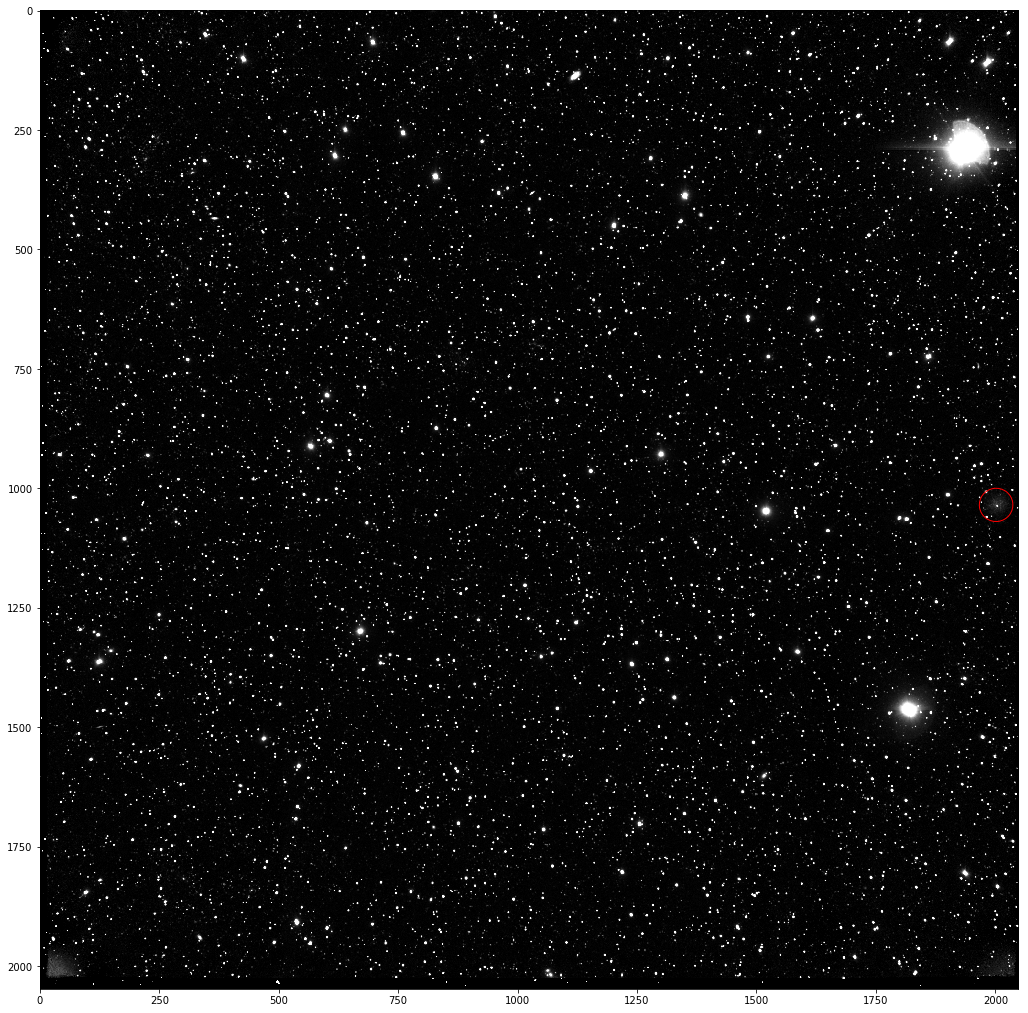

In [59]:
fig, ax = plt.subplots()
#m, s = np.mean(data_sub), np.std(data_sub)
vmin, vmax = np.percentile(d2sub, [10,99])
im = ax.imshow(d2sub, interpolation='nearest', cmap='Greys_r',
               vmin=vmin, vmax=vmax)

#objects2['thresh'].mean()
avgsb = np.mean(objects2['cflux'] / objects2['npix'])


largest = sorted(objects2, key=lambda x: x['npix'], reverse=True)[0:11]

# plot an ellipse for each object
for obj in cut_corners(largest, thresh=200):
    sb = obj['cflux'] / obj['npix']
    print(sb, end="; ")
    if sb > avgsb:
        print("skipped!")
        continue
    e = patches.Ellipse(xy=(obj['x'], obj['y']),
                width=6*obj['a'],
                height=6*obj['b'],
                angle=obj['theta'] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

In [55]:
np.mean(objects2['cflux'] / objects2['npix'])

27.77303127251153

In [134]:
img3n = butler.get_image_fn(ra=27.77625, dec=-44.4447222222)
#img3n = butler.get_image_fn(ra=168.37, dec=22.151)
img3 = fits.open(img3n)
data3 = img3[0].data

In [135]:
data3b = data3.byteswap().newbyteorder()
background3 = sep.Background(data3b)
d3sub = data3b - background3
objects3 = sep.extract(d3sub, 1.5, err=background3.globalrms)

11
21.664057941416736; 

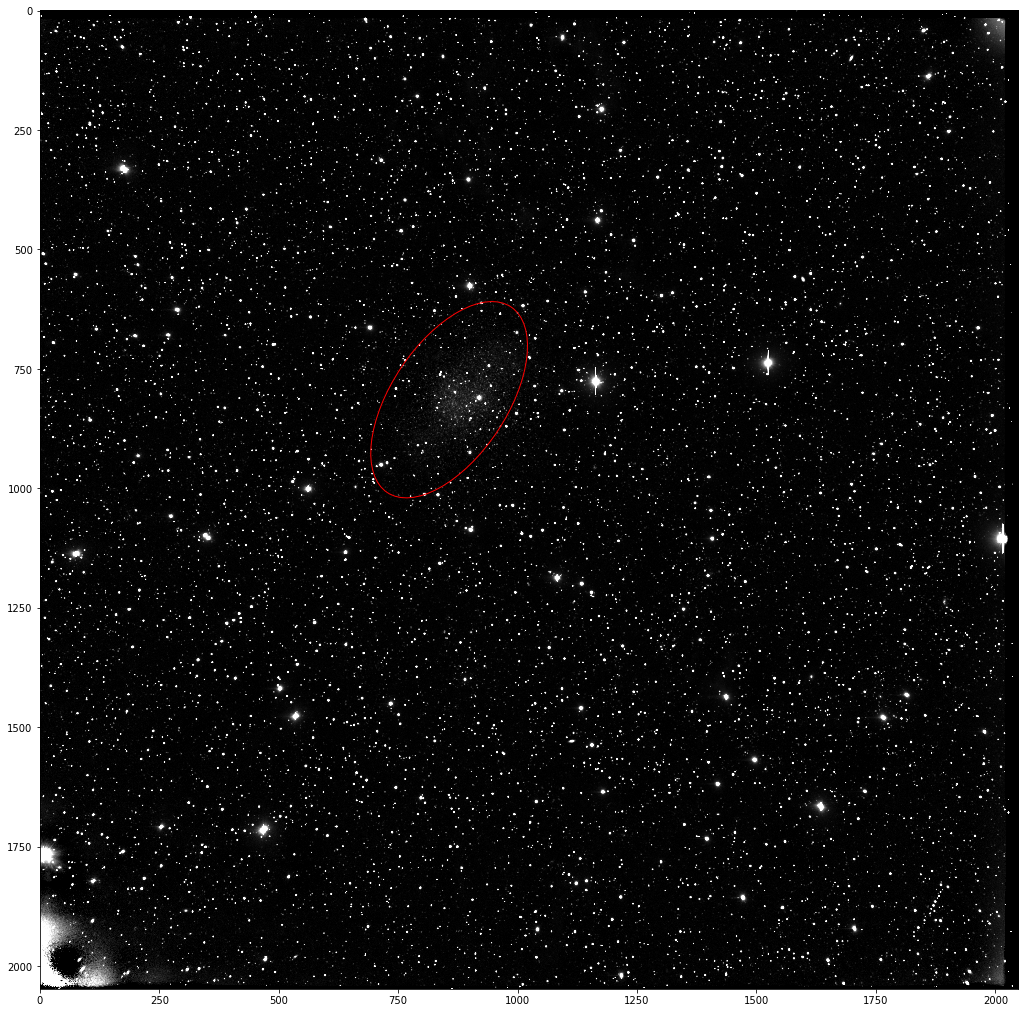

In [137]:
fig, ax = plt.subplots()
#m, s = np.mean(data_sub), np.std(data_sub)
vmin, vmax = np.percentile(d3sub, [10,99])
im = ax.imshow(d3sub, interpolation='nearest', cmap='Greys_r',
               vmin=vmin, vmax=vmax)

#objects2['thresh'].mean()

objects3 = np.array(list(cut_corners(objects3, thresh=500)))

avgsb = np.mean(objects3['cflux'] / objects3['npix'])

brightsort = sorted(objects3, key=lambda x: x['cflux'] / x['npix'])
largest = sorted(brightsort[0:int(len(brightsort) * .9)], key=lambda x: x['npix'], reverse=True)[0:11]
#largest = sorted(objects2, key=lambda x: x['npix'], reverse=True)[0:11]
print(len(largest))

# plot an ellipse for each object
for obj in largest:
    sb = obj['cflux'] / obj['npix']
    print(sb, end="; ")
    print(obj)
    if sb > avgsb:
        print("skipped!")
        continue
    else:
        e = patches.Ellipse(xy=(obj['x'], obj['y']),
                    width=6*obj['a'],
                    height=6*obj['b'],
                    angle=obj['theta'] * 180. / np.pi)
        e.set_facecolor('none')
        e.set_edgecolor('red')
        ax.add_artist(e)
        break

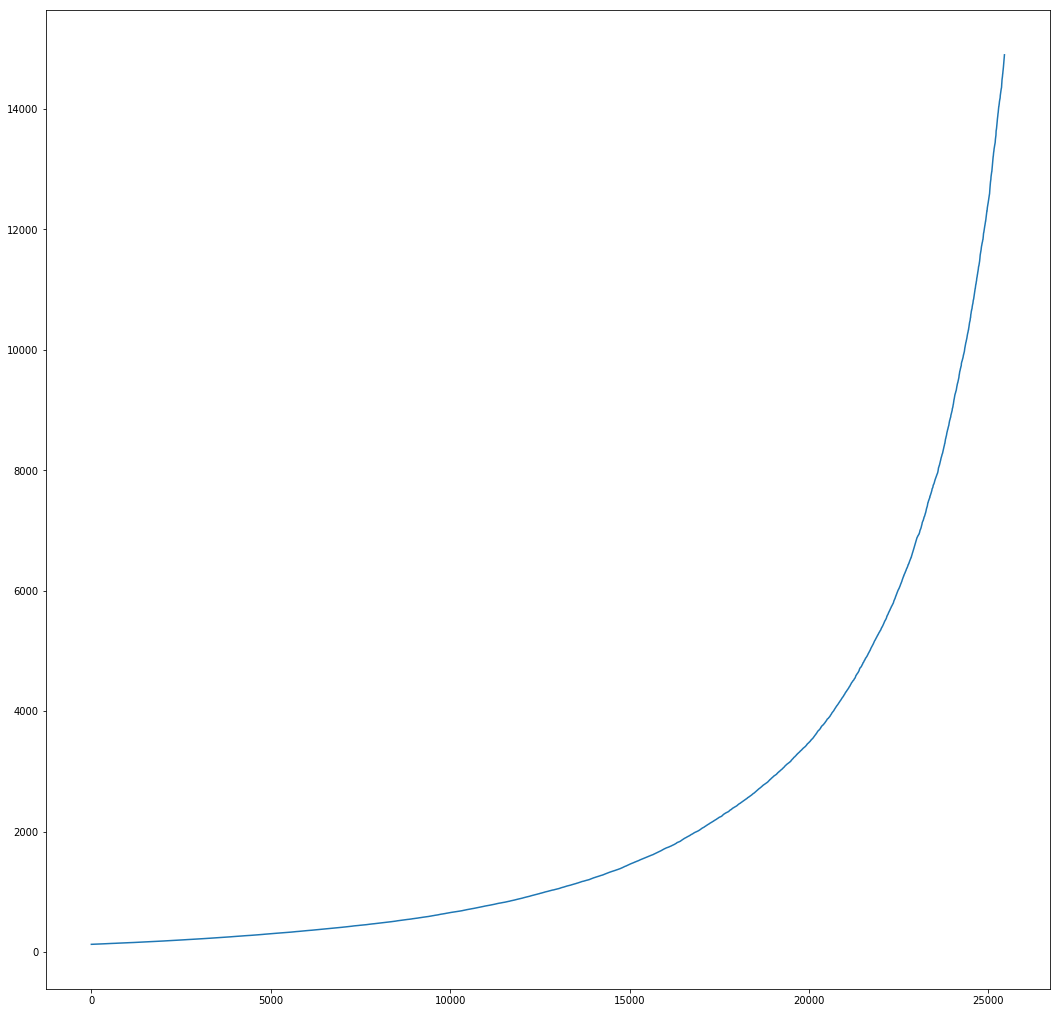

In [100]:
vmin,vmax = np.percentile(objects3['flux'],[10,99])
obj3sort = np.sort(objects3['flux'])
plt.plot(obj3sort[obj3sort.size*1//10:obj3sort.size*9//10], )